In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# %%
import os 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
 
# For a single device (GPU 5) 
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"


Num GPUs Available:  1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import argparse

# DEFINE ARGUMENTS
ap = argparse.ArgumentParser()
ap.add_argument("-t", "--train_csv", required=False,
    help="path of training csv")

ap.add_argument("-exp", "--experiment_no", required=False,
    help="Experiment counter")

ap.add_argument("-d", "--training_dir", required=False,
    help="Training image folder path")

ap.add_argument("-b", "--batch_size", required=False,
    help="Batch size", default = 256)

ap.add_argument("-lr", "--learning_rate", required=False,
    help="What is the learning rate?", default = 0.00001)

ap.add_argument("-s", "--img_size", required=False,
    help="What is the image size?", default = 67)

ap.add_argument("-e", "--epochs", required=False,
    help="How many epochs do you want to run?", default = 500)

ap.add_argument("-l", "--label", required=False,
    help="Name of the label column", default = 'Airspeed(Ind)')

ap.add_argument("-i", "--image_column", required=False,
    help="Name of the image_path column", default = 'image_path')


_StoreAction(option_strings=['-i', '--image_column'], dest='image_column', nargs=None, const=None, default='image_path', type=None, choices=None, help='Name of the image_path column', metavar=None)

In [3]:
TRAIN_CSV = "final_csvs/train_2022-01-01 13-30-31.mp4.csv"
label = 'Airspeed(Ind)'
image_path = "image_path"
EXPERIMENT_NO = 15
TRAINING_DIR = "gauge_images/2022-01-01 13-30-31.mp4/"
IMAGE_SIZE = 67
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
EPOCHS = 111
BATCH_SIZE = 32
LR = 0.001
CHECKPOINT_PATH = "./Weights/{}_Resnet50_xplane_airspeed_weights.hdf5".format(EXPERIMENT_NO)
MONITOR = 'val_loss'
xcol, ycol = image_path, label

C:\Users\Mahmu\anaconda3\envs\faa_env\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[100 101 102 103 104 105 106 107 108 109 110], y=304     109
2488    104
2414    109
3462    105
2812    106
       ... 
2856    108
1910    106
1969    105
2234    110
1552    105
Name: Airspeed(Ind), Length: 1169, dtype: int32 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


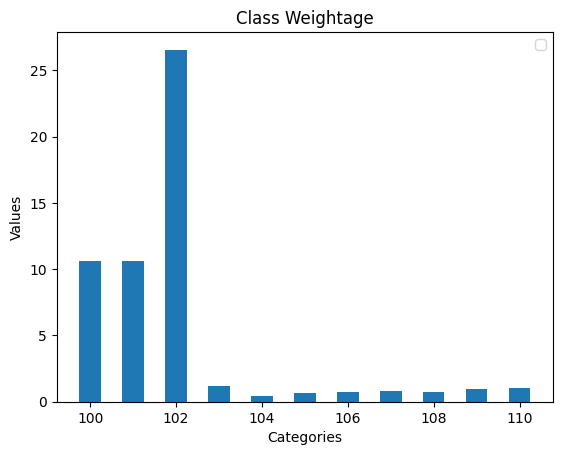

In [4]:



df = pd.read_csv('{}'.format(TRAIN_CSV), index_col = False)
df = df.drop(df[(df['Airspeed(Ind)'] < 100) | (df['Airspeed(Ind)'] > 110)].index)
df['Airspeed(Ind)'] = df['Airspeed(Ind)'].astype(int)
num_class = len(df['Airspeed(Ind)'].unique())


from sklearn.model_selection import train_test_split 

X_train, X_valid, y_train, y_valid = train_test_split(df[[image_path]], df[label], test_size = 0.5, random_state= 42) #, stratify= df[label]) 

from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(y_train),
                         class_weight.compute_class_weight('balanced', np.unique(y_train), y_train))) 


x = class_weights.keys()
y = class_weights.values()
plt.bar(x,y, 0.5)
plt.xlabel('Categories')
plt.ylabel("Values")
plt.title('Class Weightage')
plt.legend('')
plt.savefig("figures/class_weights.png")
plt.show()

In [5]:
import os
from scipy import stats
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, UpSampling2D,Dropout, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from tensorflow.keras.applications import VGG16, VGG19, InceptionV3
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras import optimizers , layers, applications
from scipy import stats
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, UpSampling2D,Dropout, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from tensorflow.keras.applications import VGG16, VGG19, InceptionV3
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, save_model
import efficientnet.tfkeras as efn

In [6]:
df_train = pd.concat([X_train,y_train],axis=1)
df_train[label] = df_train[label].astype(str) 
df_valid = pd.concat([X_valid,y_valid],axis=1)
df_valid[label] = df_valid[label].astype(str) 


#arg variables
# EXPERIMENT_NO = args.experiment_no
# TRAINING_DIR = args.training_dir
# IMAGE_SIZE = args.img_size
# INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
# EPOCHS = args.epochs
# BATCH_SIZE = args.batch_size
# LR = args.learning_rate
# CHECKPOINT_PATH = "./Weights/{}_Resnet50_xplane_airspeed_weights.hdf5".format(EXPERIMENT_NO)
# MONITOR = 'val_loss'
# xcol, ycol = image_path, label



tf.debugging.set_log_device_placement(True)
GPUS = ["GPU:0"]#,"GPU:2", "GPU:3","GPU:4","GPU:5", "GPU:6"]
strategy = tf.distribute.MirroredStrategy(GPUS)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [7]:
strategy.num_replicas_in_sync
BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60*60))
    m = int((sec_elapsed % (60*60))/60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h,m,s)

def get_model():
    pre_trained_model = VGG16(input_shape=INPUT_SHAPE, include_top=False, weights="imagenet", pooling= 'avg')
        
    last_layer = pre_trained_model.get_layer('block5_pool')
    last_output = last_layer.output

    # Flatten the output layer to 1 dimension
    x = GlobalMaxPooling2D()(last_output)
    # # Add a fully connected layer with 512 hidden units and ReLU activation
    x = Dense(256, activation='relu')(x)
    # Add a dropout rate of 0.5
    x = Dropout(0.5)(x)
    # Add a final sigmoid layer for classification
    x = layers.Dense(num_class, activation='softmax')(x)

    model = Model(pre_trained_model.input, x)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(lr= LR),
                  metrics=['accuracy'])

    model.summary()
    return model   

In [8]:
# Training Generator
train_datagen = ImageDataGenerator(
#     rotation_range=40,
    rescale=1./255,
#     shear_range=0.2,
    zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest',
#     width_shift_range=0.2,
#     height_shift_range=0.2
    brightness_range=[0.1,1.0]
)

train_generator = train_datagen.flow_from_dataframe( 
    df_train,
    TRAINING_DIR, 
    x_col=xcol,
    y_col=ycol,
    class_mode='categorical',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

total_train = df_train.shape[0]
total_validate = df_valid.shape[0]

Found 1169 validated image filenames belonging to 11 classes.


In [9]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    df_valid, 
    TRAINING_DIR, 
    x_col=xcol,
    y_col=ycol,
    class_mode='categorical',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 1169 validated image filenames belonging to 11 classes.


In [10]:
model_checkpoint_callback = ModelCheckpoint(filepath= CHECKPOINT_PATH, verbose=1, 
                               save_best_only=True, monitor= MONITOR)
early_stop = EarlyStopping(monitor= MONITOR, min_delta=0, patience=5, verbose=0)
reduce_lr = ReduceLROnPlateau(monitor=MONITOR, factor=0.2,
                              patience=3, min_lr=0.000002)

In [11]:

tf.get_logger().setLevel('ERROR')

import time
start = time.time()
with strategy.scope():
    model = get_model()
    history = model.fit(
                        train_generator,
                        
                        validation_data = validation_generator,
                        epochs = 1000,
                        callbacks = [reduce_lr, early_stop, model_checkpoint_callback],
                        verbose = 1,
                        validation_steps=total_validate//BATCH_SIZE,
                        steps_per_epoch=total_train//BATCH_SIZE)

elapsed = time.time() - start
print(f'Training time : {hms_string(elapsed)}')



plt.figure(figsize=(10,4),dpi=100)
plt.plot(history.history["accuracy"], color = 'blue' )
plt.plot(history.history["val_accuracy"], color = 'red')
plt.title('Model Accuracy')
plt.ylabel(ylabel = 'Accuracy')
plt.xlabel(xlabel = 'Epochs')

plt.legend(["train_acc","val_acc"], loc= "lower right")
plt.savefig('figures/{}_Accuracy.png'.format(EXPERIMENT_NO))

plt.figure(figsize=(10,4),dpi=100)
plt.plot(history.history["loss"], color = 'blue' )
plt.plot(history.history["val_loss"], color = 'red')
plt.title('Model Loss')
plt.ylabel(ylabel = 'Loss')
plt.xlabel(xlabel = 'Epochs')

plt.legend(["train_loss","val_loss"], loc= "lower right")
plt.savefig('figures/{}_Loss.png'.format(EXPERIMENT_NO))


Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0

KeyboardInterrupt: 